In [3]:
import skimage as ski
from skimage.morphology import medial_axis
from skimage.morphology import convex_hull_image
from skimage import measure

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL.ImageOps
from random import uniform
from scipy import ndimage
import pandas as pd

from skimage import morphology
from skan import Skeleton, summarize
from skan import draw


In [5]:
def distance_from_uniform(seq): # measure how much a distribution differs from a uniform distribution
    array = np.array(seq)
    summe = sum(seq)
    avg = summe/len(seq)
    absdevarray = abs(array-avg)
    summe2 = sum(absdevarray)
    return summe2/summe

In [11]:
def analyze_image(image):

    (dimx, dimy) = image.shape
    
    for i in range(0, 10):
      image = ski.morphology.erosion(image)
      # Dilate one pixel
      image = ski.morphology.dilation(image)

    # Compute the medial axis of the image 
    skel, distance =  medial_axis(image, return_distance=True)
    #print(f'skel shape: {skel.shape}, distance shape: {distance.shape}')
    # Multiply the distance image by the skel image to keep only the distances (local width) on the skeleton
    dist_on_skel = distance * skel

    # Print the maximum and minimum values of the dist_on_skel image
    #print(f'maximum th: {np.max(dist_on_skel)}, minimum th: {np.min(dist_on_skel)}')

    # Plot the skel and the distances map

    # Sort the pixels of the dist_on_skel image by value
    sort_px_list = np.sort(dist_on_skel.ravel())
    # Keep only the non zero values
    nonzero_pixels = sort_px_list[sort_px_list > 0]
    # Invert the list to have the highest values first
    nonzero_pixels = nonzero_pixels[::-1]    
    mean_n_width = np.mean(nonzero_pixels)
 
    # Label the connected components
    labeled_image, num_labels = ndimage.label(binary_image)

    # Get properties of labeled regions
    regions = measure.regionprops(labeled_image)

    lacunaenumber = 0

    for i, region in enumerate(regions, start=1):
        # Get the coordinates of the centroid of the region
        y, x = region.centroid
        bb = region.bbox
        # Draw the area of the domain on the image
        if region.area > 10 and bb[0]>0 and bb[2]<dimx and bb[1]>0 and bb[3]<dimy:  
     #      ax2.text(x, y, str(region.area), color='white')
           lacunaenumber += 1    

    # Determine skeleton and analyze network using skan library
    print(type(image))
    skeleton0 = morphology.skeletonize(~image)
    #fig, ax = plt.subplots()
    #draw.overlay_skeleton_2d(image, skeleton0, dilate=0, axes=ax);

    branch_data = summarize(Skeleton(skeleton0))

    branch_data = branch_data.rename(columns={"branch-type": "branchtype"})
    branch_data = branch_data.rename(columns={"branch-distance": "branchdistance"})

    branch_data.drop(branch_data[branch_data.branchtype != 2].index, inplace=True) # drop branches that are not from junction to junction
    branch_data.drop(branch_data[branch_data.branchdistance < 5.].index, inplace=True) # drop small branches

    # find direction of the branch
    branch_data['angle'] = np.arctan2(branch_data['image-coord-src-1']-branch_data['image-coord-dst-1'], branch_data['image-coord-src-0']-branch_data['image-coord-dst-0'])
    branch_data['angle'] = branch_data['angle'].astype('float')
    #print(branch_data['angle'])
    import warnings
    with warnings.catch_warnings(action="ignore"):
        branch_data.loc[branch_data['angle']<0.] = branch_data.loc[branch_data['angle']<0.] + np.pi
    #print(branch_data['angle'])
    total_network_length = branch_data['branchdistance'].sum()
    number_of_branches = branch_data.shape[0]

    # branch_data['angle'].hist(bins=20)

    hist = np.histogram(branch_data['angle'], bins=20)
    frequencies = hist[0]
    anisotropy = distance_from_uniform(frequencies)

    return mean_n_width, lacunaenumber, total_network_length, number_of_branches, anisotropy

In [15]:
workdir = "C:../../../../morpheus/Angiogenesis_sweep_L_12"
print(workdir)

firstrun = 811
lastrun = 841

firstpara = 0.0
lastpara = 0.6

parameter = "VGEF degradation rate"
parameters = np.linspace(firstpara, lastpara, num=lastrun-firstrun+1)
print(parameters)

imgnum=0

lacunaenumber_list = []
mean_n_list = []
network_length_list = []
number_of_branches_list = []
anisotropy_list = []

for run in range(firstrun, lastrun+1):
    print(run)
    filename = workdir + "/Angiogenesis_" + str(run) + "/symbol_p_00500.csv"
    print(filename)
    dataframe = pd.read_csv(filename)
    #print(dataframe)
    firstcol = dataframe.columns[0]
    dataframe = pd.read_csv(filename, index_col=firstcol)
    
    data = dataframe.to_numpy()
    
    binary_image = (data[:,:] == 0)
    
    image = binary_image
    print(image.dtype)
    mean_n_width, lacunaenumber, total_network_length, number_of_branches, anisotropy = analyze_image(image)

    mean_n_list.append(mean_n_width)
    lacunaenumber_list.append(lacunaenumber)
    network_length_list.append(total_network_length)
    number_of_branches_list.append(number_of_branches)
    anisotropy_list.append(anisotropy)

avg_branch_length_list = []
for i in range(len(network_length_list)):
    avg_branch_length_list.append(network_length_list[i] / number_of_branches_list[i])
 

C:../../../../morpheus/Angiogenesis_sweep_L_12
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6 ]
811
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_811/symbol_p_00500.csv
bool
<class 'numpy.ndarray'>
812
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_812/symbol_p_00500.csv
bool
<class 'numpy.ndarray'>
813
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_813/symbol_p_00500.csv
bool
<class 'numpy.ndarray'>
814
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_814/symbol_p_00500.csv
bool
<class 'numpy.ndarray'>
815
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_815/symbol_p_00500.csv
bool
<class 'numpy.ndarray'>
816
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_816/symbol_p_00500.csv
bool
<class 'numpy.ndarray'>
817
C:../../../../morpheus/Angiogenesis_sweep_L_12/Angiogenesis_817/symbol_p_00500.csv
bool
<class

0 0
0 1
0 2
1 0
1 1
1 2


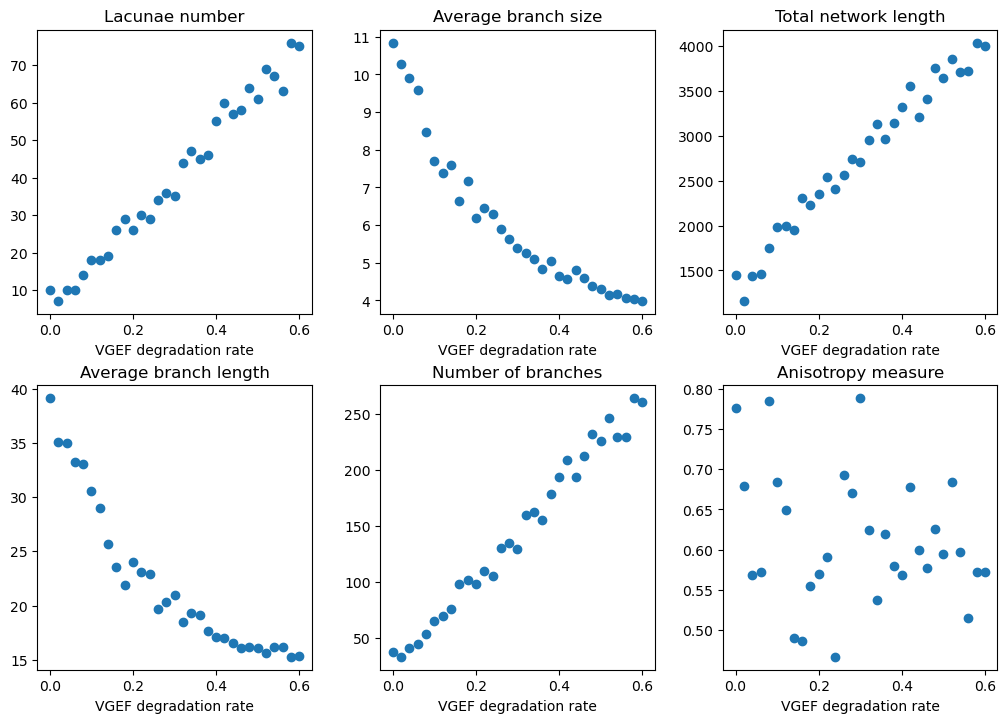

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(12)
 

for ii in range(0,2):
    for jj in range(0,3):
        print(ii,jj)
        axes[ii,jj].set_xlabel(parameter)
        
axes[0,0].scatter(parameters, lacunaenumber_list)
axes[0,0].title.set_text("Lacunae number")

axes[0,1].scatter(parameters, mean_n_list)
axes[0,1].title.set_text("Average branch size")

axes[0,2].scatter(parameters, network_length_list)
axes[0,2].title.set_text("Total network length")

axes[1,0].scatter(parameters, avg_branch_length_list)
axes[1,0].title.set_text("Average branch length")

axes[1,1].scatter(parameters, number_of_branches_list)
axes[1,1].title.set_text("Number of branches")

axes[1,2].scatter(parameters, anisotropy_list)
axes[1,2].title.set_text("Anisotropy measure")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.25)